##Preprocessing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Semester 4/MPML/UTS - Pendidikan dan Pendapatan Jakarta/data_uts.xlsx')

Proses penggabungan dan preprocessing data dilakukan di excel

In [ ]:
data

,kab_kot,rls_avg,laju_pdrb_ctoc,pdrb_per_kapita
0,Kep Seribu,9.265,-1.7225,113454
1,Jakarta Selatan,12.040,5.2250,224339
2,Jakarta Timur,12.065,4.2400,117326
3,Jakarta Pusat,11.615,5.1575,510015
4,Jakarta Barat,11.240,5.2400,154508
5,Jakarta Utara,10.885,4.0075,209550


Penjelasan Variabel :
*   rls_avg: rata-rata lama sekolah (indikator pendidikan)
*   laju_pdrb_ctoc: estimasi pertumbuhan ekonomi
*   pdrb_per_kapita: pendapatan rata-rata



###Standardisasi Data
Karena skala ketiga variabel berbeda, kita perlu menstandarkan nilainya.

In [ ]:
from sklearn.preprocessing import StandardScaler
X = data[['rls_avg', 'laju_pdrb_ctoc', 'pdrb_per_kapita']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,rls_avg,laju_pdrb_ctoc,pdrb_per_kapita
0,-2.010912,-2.191642,-0.796740
1,0.895484,0.620906,0.020693
2,0.921668,0.222150,-0.768196
3,0.450361,0.593580,2.126669
4,0.057604,0.626979,-0.494094


##Clustering

###K-Means Clustering

####Elbow Method

Menentukan nilai k dengan metode elbow terlebih dahulu:

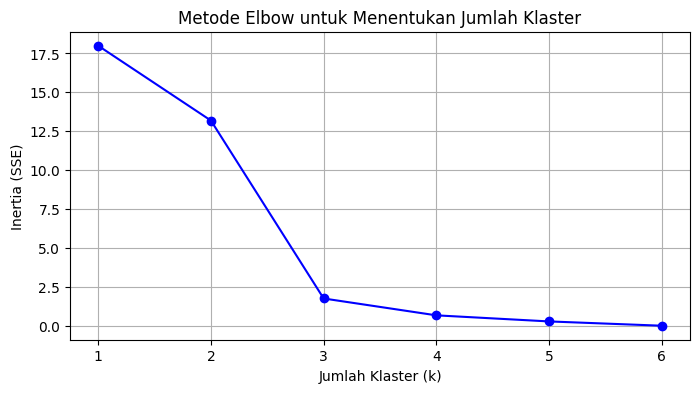

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(1, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot hasil Elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Metode Elbow untuk Menentukan Jumlah Klaster')
plt.grid(True)
plt.show()

elbow terjadi di k = 3, maka nilai k yang optimal untuk clustering k-means adalah 3

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster_kmeans'] = kmeans.fit_predict(X_scaled)
data[['kab_kot', 'cluster_kmeans']]

,kab_kot,cluster_kmeans
0,Kep Seribu,2
1,Jakarta Selatan,1
2,Jakarta Timur,1
3,Jakarta Pusat,0
4,Jakarta Barat,1
5,Jakarta Utara,1


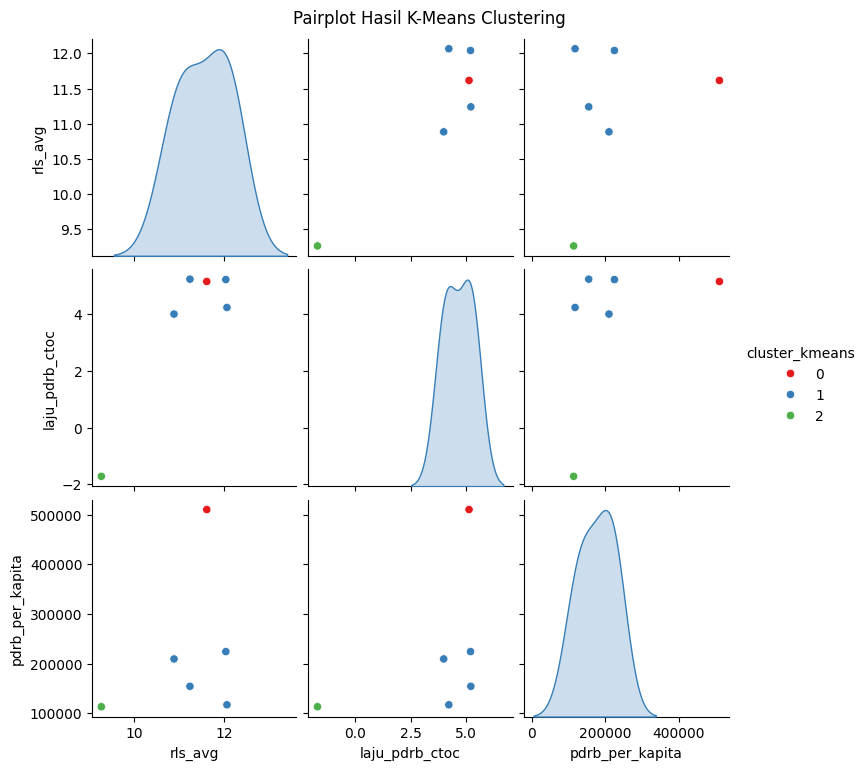

In [ ]:
sns.pairplot(data, vars=['rls_avg', 'laju_pdrb_ctoc', 'pdrb_per_kapita'], hue='cluster_kmeans', palette='Set1')
plt.suptitle('Pairplot Hasil K-Means Clustering', y=1.02)
plt.show()

###Hierarchical Clustering

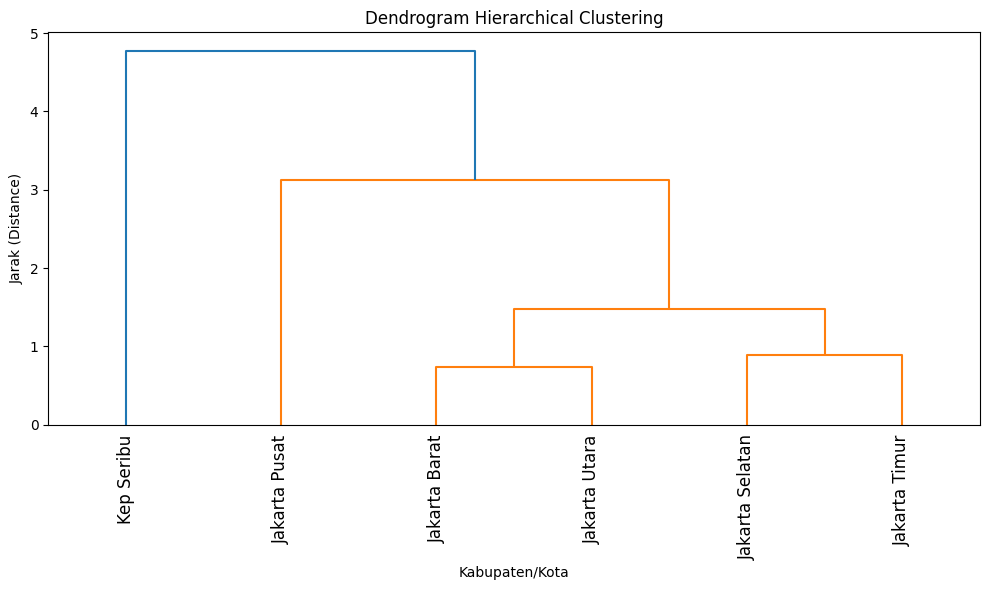

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
linkage_matrix = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(
    linkage_matrix,
    labels=data['kab_kot'].values,
    leaf_rotation=90,
    leaf_font_size=12
)
plt.title('Dendrogram Hierarchical Clustering')
plt.xlabel('Kabupaten/Kota')
plt.ylabel('Jarak (Distance)')
plt.tight_layout()
plt.show()

In [ ]:
data['cluster_hierarchical'] = fcluster(linkage_matrix, 3, criterion='maxclust')
data[['kab_kot', 'cluster_hierarchical']]

,kab_kot,cluster_hierarchical
0,Kep Seribu,3
1,Jakarta Selatan,1
2,Jakarta Timur,1
3,Jakarta Pusat,2
4,Jakarta Barat,1
5,Jakarta Utara,1


Berdasarkan hasil dendrogram, wilayah yang mempunyai karakteristik paling mirip dinilai dari seberapa kecil jaraknya. Hal ini membuat Jakarta Barat, Jakarta Utara, Jakarta Selatan, dan Jakarta Timur menjadi satu kluster karena mereka digabungkan pada tingkat jarak kurang dari 1.5 , yang menunjukkan bahwa mereka memiliki karakteristik yang sangat mirip.

Lalu, Jakarta Pusat memiliki jarak yang lebih besar (sekitar 3.0 ) saat digabungkan dengan klaster sebelumnya, sehingga Jakarta Pusat memiliki karakteristik yang sedikit berbeda dibandingkan dengan kelompok utama tersebut.

Terakhir, Kepulauan Seribu memiliki jarak tertinggi (4.8 ) saat digabungkan dengan wilayah Jakarta lainnya, yang menunjukkan bahwa Kepulauan Seribu memiliki karakteristik yang sangat berbeda dibandingkan dengan wilayah Jakarta lainnya.

###DbScans Clustering

Untuk mencari nilai eps dari Dbscans, diketahui dari nilai dimana elbow berada pada k-distance plot

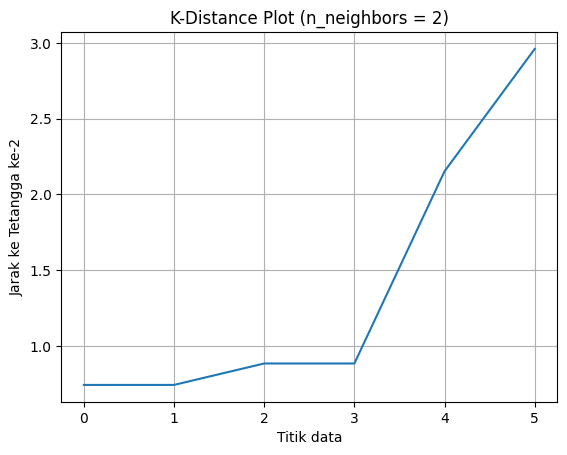

In [ ]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 1])
plt.plot(distances)
plt.title("K-Distance Plot (n_neighbors = 2)")
plt.xlabel("Titik data")
plt.ylabel("Jarak ke Tetangga ke-2")
plt.grid(True)
plt.show()

Didapatkan nilai eps optimalnya adalah sekitar 0.9, dan min_samples = 2 karena data hanya ada 6 observasi


In [ ]:
from sklearn.cluster import DBSCAN

# DBSCAN dengan parameter awal
dbscan = DBSCAN(eps=0.9, min_samples=2)
data['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

data[['kab_kot', 'cluster_dbscan']]

,kab_kot,cluster_dbscan
0,Kep Seribu,-1
1,Jakarta Selatan,0
2,Jakarta Timur,0
3,Jakarta Pusat,-1
4,Jakarta Barat,1
5,Jakarta Utara,1


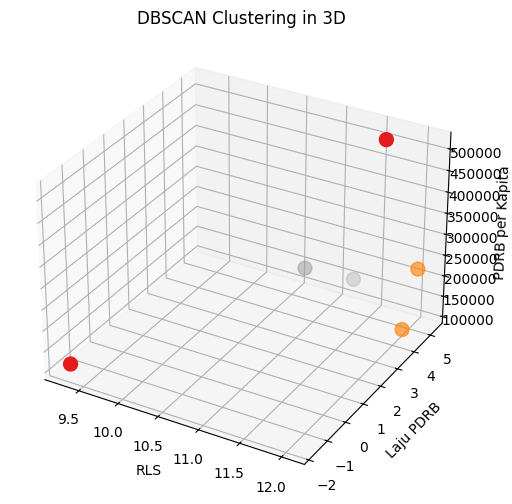

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    data['rls_avg'],
    data['laju_pdrb_ctoc'],
    data['pdrb_per_kapita'],
    c=data['cluster_dbscan'],
    cmap='Set1',
    s=100
)
ax.set_xlabel('RLS')
ax.set_ylabel('Laju PDRB')
ax.set_zlabel('PDRB per Kapita')
ax.set_title('DBSCAN Clustering in 3D')
plt.show()


Dengan DBSCAN (eps=0.9, min_samples=2), terbentuk dua klaster utama yang mencerminkan kelompok wilayah dengan karakteristik ekonomi dan pendidikan yang mirip. Jakarta Pusat dan Kepulauan Seribu teridentifikasi sebagai outlier

##Evaluasi dan Analisis Hasil

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
scores = {}
# KMeans
labels_kmeans = data['cluster_kmeans']
scores['KMeans'] = {
    'Silhouette': silhouette_score(X_scaled, labels_kmeans),
    'DBI': davies_bouldin_score(X_scaled, labels_kmeans)
}
# Hierarchical
labels_hier = data['cluster_hierarchical']
scores['Hierarchical'] = {
    'Silhouette': silhouette_score(X_scaled, labels_hier),
    'DBI': davies_bouldin_score(X_scaled, labels_hier)
}
# DBSCAN
labels_dbscan = data['cluster_dbscan']
if len(set(labels_dbscan)) > 1 and len(set(labels_dbscan)) != 1 + (-1 in labels_dbscan):
    mask = labels_dbscan != -1
    scores['DBSCAN'] = {
        'Silhouette': silhouette_score(X_scaled[mask], labels_dbscan[mask]),
        'DBI': davies_bouldin_score(X_scaled[mask], labels_dbscan[mask])
    }
else:
    scores['DBSCAN'] = {
        'Silhouette': 'N/A (only one cluster or all noise)',
        'DBI': 'N/A'
    }
import pandas as pd
pd.DataFrame(scores).T

,Silhouette,DBI
KMeans,0.385169,0.235728
Hierarchical,0.385169,0.235728
DBSCAN,0.299243,0.781485


###Metode mana yang menghasilkan pemisahan kluster terbaik dan bermakna?

Berdasarkan metrik dan kesesuaian karakteristik metode , K-means clustering menghasilkan pemisahan cluster terbaik **untuk data ini**, mengapa demikian? dilihat dari metrik DBI 0.23 (semakin mendekati 0 semakin baik) dan Silhoutte 0.38 (semakin mendekati 1 semakin baik), hirearchical menunjukkan performa yang cukup baik dalam hal pemisahan kluster,

Dari sisi kesesuaian metode, K-Means sangat efektif dalam menggambarkan keterkaitan antara variabel seperti pendidikan dan pendapatan, karena setiap klaster yang terbentuk dapat langsung dianalisis berdasarkan nilai rata-rata dari fitur yang digunakan. Ini memudahkan dalam menyusun narasi dan menyampaikan insight substantif dari masing-masing kelompok wilayah. Berbeda dengan Hierarchical Clustering yang hanya menunjukkan jarak antar titik tanpa informasi eksplisit tentang nilai variabel, K-Means memberikan output yang lebih terstruktur untuk keperluan perumusan kebijakan berbasis data.

Selain itu, K-Means lebih sederhana dan efisien secara komputasi, serta lebih mudah digunakan untuk analisis replikasi atau segmentasi lanjutan. Meski memerlukan penetapan jumlah klaster (k) di awal, hal ini justru memberi kendali dan fokus analisis yang lebih jelas sesuai tujuan eksplorasi data.

###Interpretasi hasil kluster, adakah pola unik untuk setiap wilayah?
Ya, hasil klustering menunjukkan adanya pola unik di beberapa wilayah. Misalnya, Kepulauan Seribu cenderung menjadi outlier karena memiliki tingkat pendidikan dan pendapatan yang paling rendah, sementara Jakarta Pusat memiliki pendapatan per kapita tertinggi namun tidak selalu diikuti dengan pertumbuhan ekonomi yang paling tinggi. Wilayah lain seperti Jakarta Selatan, Barat, dan Timur cenderung membentuk klaster yang lebih stabil, dengan kombinasi pendidikan dan ekonomi yang cukup seimbang. Ini menunjukkan bahwa setiap wilayah memiliki karakteristik tersendiri yang bisa menjadi dasar dalam perencanaan kebijakan berbasis data.

##Interpretation

####Kesimpulan
Berdasarkan hasil dari K-means clustering yang dinilai paling relevan untuk kasus pengelompokan wilayah berdasarkan pendapatan dan pendidikan, peneliti mengambil kesimpulan dan saran sebagai berikut:

| Cluster | Karakteristik                          | Kebijakan yang Relevan                         |
| ------- | -------------------------------------- | ---------------------------------------------- |
| 0       | Pusat ekonomi dan pendidikan tinggi    | Inovasi, riset, dan pengembangan digital       |
| 1       | Stabil, menengah ke atas               | Penguatan SDM, pelatihan vokasi, inkubasi UMKM |
| 2       | Terpencil, pendidikan & ekonomi rendah | Intervensi pendidikan dasar, infrastruktur     |


Cluster 0 – Elit dan Pusat Ekonomi
Cluster ini hanya berisi Jakarta Pusat, wilayah dengan rata-rata lama sekolah tinggi, pendapatan per kapita tertinggi (lebih dari Rp 500 juta), dan pertumbuhan ekonomi yang cukup stabil. Ini mencerminkan wilayah yang paling maju dari segi pendidikan dan ekonomi. Cocok untuk kebijakan pengembangan inovasi, teknologi, dan pusat riset.

Cluster 1 – Wilayah Stabil Berkembang
Cluster ini mencakup Jakarta Selatan, Jakarta Timur, Jakarta Barat, dan Jakarta Utara. Wilayah-wilayah ini memiliki RLS di atas rata-rata nasional (11–12 tahun), pendapatan per kapita menengah (150–220 juta), dan pertumbuhan ekonomi antara 4–5%. Cocok untuk program penguatan SDM, pelatihan vokasi, dan pengembangan UMKM agar naik kelas secara ekonomi.

Cluster 2 – Wilayah Tertinggal
Cluster ini hanya berisi Kepulauan Seribu, yang menunjukkan tantangan terbesar: RLS rendah (9.2 tahun), pendapatan per kapita terendah (Rp 113 juta), dan pertumbuhan ekonomi negatif. Sangat membutuhkan intervensi serius di bidang pendidikan dasar, infrastruktur, dan akses layanan publik.